In [6]:
def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)

In [7]:
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
import torch.nn.functional as F
import rl_utils
import copy

In [8]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class TRPO:
    """ TRPO算法 """
    def __init__(self, hidden_dim, state_space, action_space, lmbda,
                 kl_constraint, alpha, critic_lr, gamma, device):
        state_dim = state_space.shape[0]
        action_dim = action_space.n
        # 策略网络参数不需要优化器更新
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda  # GAE参数
        self.kl_constraint = kl_constraint  # KL距离最大限制
        self.alpha = alpha  # 线性搜索参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def hessian_matrix_vector_product(self, states, old_action_dists, vector):
        # 计算黑塞矩阵和一个向量的乘积
        new_action_dists = torch.distributions.Categorical(self.actor(states))
        kl = torch.mean(
            torch.distributions.kl.kl_divergence(old_action_dists,
                                                 new_action_dists))  # 计算平均KL距离
        kl_grad = torch.autograd.grad(kl,
                                      self.actor.parameters(),
                                      create_graph=True)
        kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])
        # KL距离的梯度先和向量进行点积运算
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        grad2 = torch.autograd.grad(kl_grad_vector_product,
                                    self.actor.parameters())
        grad2_vector = torch.cat([grad.view(-1) for grad in grad2])
        return grad2_vector

    def conjugate_gradient(self, grad, states, old_action_dists):  # 共轭梯度法求解方程
        x = torch.zeros_like(grad)
        r = grad.clone()
        p = grad.clone()
        rdotr = torch.dot(r, r)
        for i in range(10):  # 共轭梯度主循环
            Hp = self.hessian_matrix_vector_product(states, old_action_dists,
                                                    p)
            alpha = rdotr / torch.dot(p, Hp)
            x += alpha * p
            r -= alpha * Hp
            new_rdotr = torch.dot(r, r)
            if new_rdotr < 1e-10:
                break
            beta = new_rdotr / rdotr
            p = r + beta * p
            rdotr = new_rdotr
        return x

    def compute_surrogate_obj(self, states, actions, advantage, old_log_probs,
                              actor):  # 计算策略目标
        log_probs = torch.log(actor(states).gather(1, actions))
        ratio = torch.exp(log_probs - old_log_probs)
        return torch.mean(ratio * advantage)

    def line_search(self, states, actions, advantage, old_log_probs,
                    old_action_dists, max_vec):  # 线性搜索
        old_para = torch.nn.utils.convert_parameters.parameters_to_vector(
            self.actor.parameters())
        old_obj = self.compute_surrogate_obj(states, actions, advantage,
                                             old_log_probs, self.actor)
        for i in range(15):  # 线性搜索主循环
            coef = self.alpha**i
            new_para = old_para + coef * max_vec
            new_actor = copy.deepcopy(self.actor)
            torch.nn.utils.convert_parameters.vector_to_parameters(
                new_para, new_actor.parameters())
            new_action_dists = torch.distributions.Categorical(
                new_actor(states))
            kl_div = torch.mean(
                torch.distributions.kl.kl_divergence(old_action_dists,
                                                     new_action_dists))
            new_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                 old_log_probs, new_actor)
            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
        return old_para

    def policy_learn(self, states, actions, old_action_dists, old_log_probs,
                     advantage):  # 更新策略函数
        surrogate_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                   old_log_probs, self.actor)
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()
        # 用共轭梯度法计算x = H^(-1)g
        descent_direction = self.conjugate_gradient(obj_grad, states,
                                                    old_action_dists)

        Hd = self.hessian_matrix_vector_product(states, old_action_dists,
                                                descent_direction)
        max_coef = torch.sqrt(2 * self.kl_constraint /
                              (torch.dot(descent_direction, Hd) + 1e-8))
        new_para = self.line_search(states, actions, advantage, old_log_probs,
                                    old_action_dists,
                                    descent_direction * max_coef)  # 线性搜索
        torch.nn.utils.convert_parameters.vector_to_parameters(
            new_para, self.actor.parameters())  # 用线性搜索后的参数更新策略

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda,
                                      td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1,
                                                            actions)).detach()
        old_action_dists = torch.distributions.Categorical(
            self.actor(states).detach())
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()  # 更新价值函数
        # 更新策略函数
        self.policy_learn(states, actions, old_action_dists, old_log_probs,
                          advantage)

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\CRS\AppData\Local\Temp\ipykernel_18160\665461131.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
d:\Anaconda\envs\ailab\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Iteration 9: 100%|██████████| 50/50 [00:06<00:00,  7.92it/s, episode=500, return=338.400]


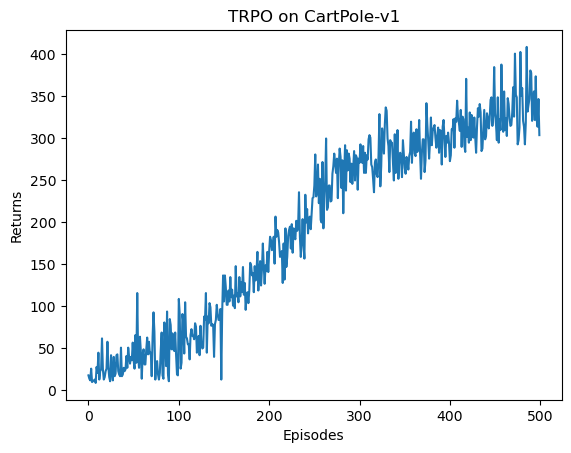

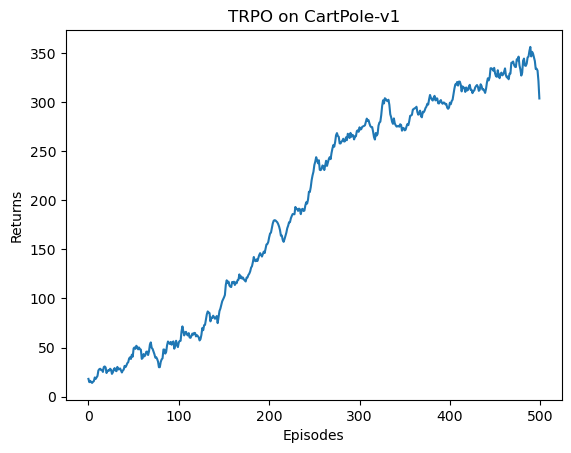

In [9]:
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
critic_lr = 1e-2
kl_constraint = 0.0005
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name,render_mode=None)
env.reset(seed=0)
torch.manual_seed(0)
agent = TRPO(hidden_dim, env.observation_space, env.action_space, lmbda,
             kl_constraint, alpha, critic_lr, gamma, device)
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

# Iteration 0: 100%|██████████| 50/50 [00:02<00:00, 16.85it/s, episode=50,
# return=139.200]
# Iteration 1: 100%|██████████| 50/50 [00:03<00:00, 16.55it/s, episode=100,
# return=150.500]
# Iteration 2: 100%|██████████| 50/50 [00:03<00:00, 14.21it/s, episode=150,
# return=184.000]
# Iteration 3: 100%|██████████| 50/50 [00:03<00:00, 14.15it/s, episode=200,
# return=183.600]
# Iteration 4: 100%|██████████| 50/50 [00:03<00:00, 13.96it/s, episode=250,
# return=183.500]
# Iteration 5: 100%|██████████| 50/50 [00:03<00:00, 13.29it/s, episode=300,
# return=193.700]
# Iteration 6: 100%|██████████| 50/50 [00:03<00:00, 14.08it/s, episode=350,
# return=199.500]
# Iteration 7: 100%|██████████| 50/50 [00:03<00:00, 13.36it/s, episode=400,
# return=200.000]
# Iteration 8: 100%|██████████| 50/50 [00:03<00:00, 13.33it/s, episode=450,
# return=200.000]
# Iteration 9: 100%|██████████| 50/50 [00:03<00:00, 13.08it/s, episode=500,
# return=200.000]

In [10]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std  # 高斯分布的均值和标准差


class TRPOContinuous:
    """ 处理连续动作的TRPO算法 """
    def __init__(self, hidden_dim, state_space, action_space, lmbda,
                 kl_constraint, alpha, critic_lr, gamma, device):
        state_dim = state_space.shape[0]
        action_dim = action_space.shape[0]
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,
                                         action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.kl_constraint = kl_constraint
        self.alpha = alpha
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, std = self.actor(state)
        action_dist = torch.distributions.Normal(mu, std)
        action = action_dist.sample()
        return [action.item()]

    def hessian_matrix_vector_product(self,
                                      states,
                                      old_action_dists,
                                      vector,
                                      damping=0.1):
        mu, std = self.actor(states)
        new_action_dists = torch.distributions.Normal(mu, std)
        kl = torch.mean(
            torch.distributions.kl.kl_divergence(old_action_dists,
                                                 new_action_dists))
        kl_grad = torch.autograd.grad(kl,
                                      self.actor.parameters(),
                                      create_graph=True)
        kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        grad2 = torch.autograd.grad(kl_grad_vector_product,
                                    self.actor.parameters())
        grad2_vector = torch.cat(
            [grad.contiguous().view(-1) for grad in grad2])
        return grad2_vector + damping * vector

    def conjugate_gradient(self, grad, states, old_action_dists):
        x = torch.zeros_like(grad)
        r = grad.clone()
        p = grad.clone()
        rdotr = torch.dot(r, r)
        for i in range(10):
            Hp = self.hessian_matrix_vector_product(states, old_action_dists,
                                                    p)
            alpha = rdotr / torch.dot(p, Hp)
            x += alpha * p
            r -= alpha * Hp
            new_rdotr = torch.dot(r, r)
            if new_rdotr < 1e-10:
                break
            beta = new_rdotr / rdotr
            p = r + beta * p
            rdotr = new_rdotr
        return x

    def compute_surrogate_obj(self, states, actions, advantage, old_log_probs,
                              actor):
        mu, std = actor(states)
        action_dists = torch.distributions.Normal(mu, std)
        log_probs = action_dists.log_prob(actions)
        ratio = torch.exp(log_probs - old_log_probs)
        return torch.mean(ratio * advantage)

    def line_search(self, states, actions, advantage, old_log_probs,
                    old_action_dists, max_vec):
        old_para = torch.nn.utils.convert_parameters.parameters_to_vector(
            self.actor.parameters())
        old_obj = self.compute_surrogate_obj(states, actions, advantage,
                                             old_log_probs, self.actor)
        for i in range(15):
            coef = self.alpha**i
            new_para = old_para + coef * max_vec
            new_actor = copy.deepcopy(self.actor)
            torch.nn.utils.convert_parameters.vector_to_parameters(
                new_para, new_actor.parameters())
            mu, std = new_actor(states)
            new_action_dists = torch.distributions.Normal(mu, std)
            kl_div = torch.mean(
                torch.distributions.kl.kl_divergence(old_action_dists,
                                                     new_action_dists))
            new_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                 old_log_probs, new_actor)
            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
        return old_para

    def policy_learn(self, states, actions, old_action_dists, old_log_probs,
                     advantage):
        surrogate_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                   old_log_probs, self.actor)
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()
        descent_direction = self.conjugate_gradient(obj_grad, states,
                                                    old_action_dists)
        Hd = self.hessian_matrix_vector_product(states, old_action_dists,
                                                descent_direction)
        max_coef = torch.sqrt(2 * self.kl_constraint /
                              (torch.dot(descent_direction, Hd) + 1e-8))
        new_para = self.line_search(states, actions, advantage, old_log_probs,
                                    old_action_dists,
                                    descent_direction * max_coef)
        torch.nn.utils.convert_parameters.vector_to_parameters(
            new_para, self.actor.parameters())

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        rewards = (rewards + 8.0) / 8.0  # 对奖励进行修改,方便训练
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda,
                                      td_delta.cpu()).to(self.device)
        mu, std = self.actor(states)
        old_action_dists = torch.distributions.Normal(mu.detach(),
                                                      std.detach())
        old_log_probs = old_action_dists.log_prob(actions)
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        self.policy_learn(states, actions, old_action_dists, old_log_probs,
                          advantage)

Iteration 9: 100%|██████████| 200/200 [00:17<00:00, 11.52it/s, episode=2000, return=-282.813]


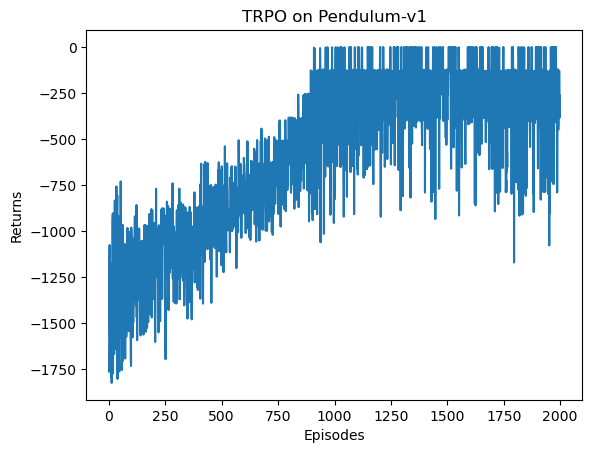

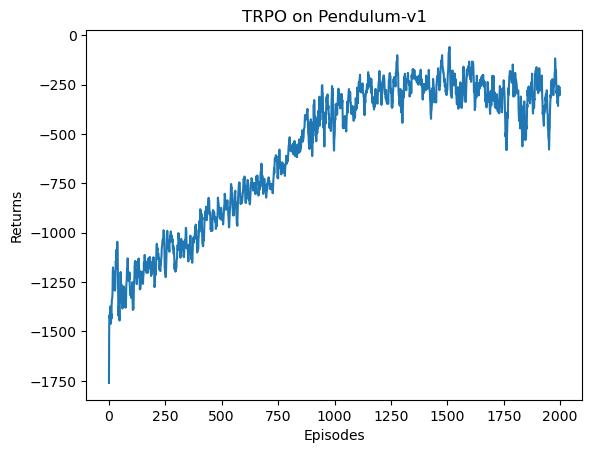

In [13]:
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
critic_lr = 1e-2
kl_constraint = 0.00005
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
agent = TRPOContinuous(hidden_dim, env.observation_space, env.action_space,
                       lmbda, kl_constraint, alpha, critic_lr, gamma, device)
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

# Iteration 0: 100%|██████████| 200/200 [00:19<00:00, 10.00it/s, episode=200,
# return=-1181.390]
# Iteration 1: 100%|██████████| 200/200 [00:20<00:00,  9.98it/s, episode=400,
# return=-994.876]
# Iteration 2: 100%|██████████| 200/200 [00:20<00:00,  9.86it/s, episode=600,
# return=-888.498]
# Iteration 3: 100%|██████████| 200/200 [00:20<00:00,  9.94it/s, episode=800,
# return=-848.329]
# Iteration 4: 100%|██████████| 200/200 [00:20<00:00,  9.87it/s, episode=1000,
# return=-772.392]
# Iteration 5: 100%|██████████| 200/200 [00:20<00:00,  9.91it/s, episode=1200,
# return=-611.870]
# Iteration 6: 100%|██████████| 200/200 [00:20<00:00,  9.89it/s, episode=1400,
# return=-397.705]
# Iteration 7: 100%|██████████| 200/200 [00:20<00:00,  9.95it/s, episode=1600,
# return=-268.498]
# Iteration 8: 100%|██████████| 200/200 [00:20<00:00,  9.87it/s, episode=1800,
# return=-408.976]
# Iteration 9: 100%|██████████| 200/200 [00:19<00:00, 10.08it/s, episode=2000,
# return=-296.363]